In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
log = pd.read_csv('BPIC19.csv')
log['time:timestamp'] = pd.to_datetime(log['time:timestamp'], utc=True)

In [306]:
#filter start date
start_date = pd.to_datetime("2018-01-01", utc=True)
log = log[log['time:timestamp'] >= start_date]
log = log.sort_values(by='time:timestamp')

In [307]:
#filter end date
end_date = pd.to_datetime("2019-02-01", utc=True)
log = log[log['time:timestamp'] <= end_date]
log = log.sort_values(by='time:timestamp')

In [308]:
def limited_duration(dataset, max_duration):
    '''

    limits dataset to cases shorter than maximal duration and debiases the end of the dataset
    by dropping cases starting after the last timestamp of the dataset - max_duration
    Args:
        dataset: pandas DataFrame
        max_duration: float

    Returns:
        dataset: pandas Dataframe
        latest_start: timeStamp with new end time for the dataset

    '''
    # compute each case's duration
    agg_dict = {"time:timestamp" :['min', 'max']}
    duration_df = pd.DataFrame(dataset.groupby("case:concept:name").agg(agg_dict)).reset_index()
    duration_df["duration"] = (duration_df[("time:timestamp","max")] - duration_df[("time:timestamp","min")]).dt.total_seconds() / (24 * 60 * 60)
    # condition 1: cases are shorter than max_duration
    condition_1 = duration_df["duration"] <= max_duration *1.00000000001
    cases_retained = duration_df[condition_1]["case:concept:name"].values
    dataset = dataset[dataset["case:concept:name"].isin(cases_retained)].reset_index(drop=True)
    return dataset, -1

In [309]:
log.drop_duplicates(inplace=True)
log=limited_duration(log, 143.33)[0]

In [310]:
log["time:timestamp"] = pd.to_datetime(log["time:timestamp"], utc=True)
# log_start["remtime"] = log_start.groupby("case:concept:name")["time:timestamp"].apply(lambda x: x.max() - x).values
# log_start["remtime"] = log_start["remtime"].dt.total_seconds() / (24 * 60 * 60)  # convert to float days

log["remtime"] = log.groupby("case:concept:name")["time:timestamp"].transform(lambda x: (x.max() - x).dt.total_seconds() / (24 * 60 * 60))

### Get all the experiment datasets

In [10]:
#overlap remove
def overlap_remove_split(log_df, discard_date):

    # preliminaries
    case_starts_df = log_df.groupby("case:concept:name")["time:timestamp"].min()
    case_starts_dff = log_df.groupby("case:concept:name")["time:timestamp"].min().to_frame()  

    #iteratively discard cases after the drift point
    specific_date = pd.to_datetime(discard_date, utc=True)
    cases_to_remove = case_starts_dff[(case_starts_dff['time:timestamp'] > specific_date)].index.array
    clean_df = log_df[~log_df["case:concept:name"].isin(cases_to_remove)]
    
     #split
    ### TEST SET ###
    case_starts_df = clean_df.groupby("case:concept:name")["time:timestamp"].min()
    case_starts_dff = clean_df.groupby("case:concept:name")["time:timestamp"].min().to_frame()  
    case_nr_list_start = case_starts_df.sort_values().index.array
    
    first_test_case_nr = int(len(case_nr_list_start) * 0.7)
    first_test_start_time = np.sort(case_starts_df.values)[first_test_case_nr]
    # retain cases that end after first_test_start time
    test_case_nrs = case_starts_dff[case_starts_dff["time:timestamp"].values >= first_test_start_time].index.array
    test_set = clean_df[clean_df["case:concept:name"].isin(test_case_nrs)].reset_index(drop=True)
    #### TRAINING SET ###
    train_case_nrs = case_starts_dff[case_starts_dff["time:timestamp"].values < first_test_start_time].index.array  # added values
    df_train_all = clean_df[clean_df["case:concept:name"].isin(train_case_nrs)].reset_index(drop=True)

    # drop prefixes in train set that are past latest_start
    train_set = df_train_all[df_train_all["time:timestamp"].values< first_test_start_time]
    
    return train_set, test_set

In [11]:
def with_overlap_split(log_df, discard_date):
    # preliminaries
    case_starts_df = log_df.groupby("case:concept:name")["time:timestamp"].min()
    case_starts_dff = log_df.groupby("case:concept:name")["time:timestamp"].min().to_frame()  

    #iteratively discard cases after the drift point
    specific_date = pd.to_datetime(discard_date, utc=True)
    cases_to_remove = case_starts_dff[(case_starts_dff['time:timestamp'] > specific_date)].index.array
    clean_df = log_df[~log_df["case:concept:name"].isin(cases_to_remove)]
    
    #split
    # preliminaries
    case_starts_df = clean_df.groupby("case:concept:name")["time:timestamp"].min()
    case_starts_dff = clean_df.groupby("case:concept:name")["time:timestamp"].min().to_frame()  
    case_nr_list_start = case_starts_df.sort_values().index.array

    ### TEST SET ###
    first_test_case_nr = int(len(case_nr_list_start) * 0.7)
    first_test_start_time = np.sort(case_starts_df.values)[first_test_case_nr]
    # retain cases that end after first_test_start time
    test_case_nrs = case_starts_dff[case_starts_dff["time:timestamp"].values >= first_test_start_time].index.array
    df_test_clean = clean_df[clean_df["case:concept:name"].isin(test_case_nrs)].reset_index(drop=True)
    #### TRAINING SET ###
    train_case_nrs = case_starts_dff[case_starts_dff["time:timestamp"].values < first_test_start_time].index.array  # added values
    df_train_clean = clean_df[clean_df["case:concept:name"].isin(train_case_nrs)].reset_index(drop=True)
    
    return df_train_clean, df_test_clean

In [12]:
#no discarding and no overlap removal
def split_no_discard_with_overlap(log_df, ratio):
    # preliminaries
    case_starts_df = log_df.groupby("case:concept:name")["time:timestamp"].min()
    case_starts_dff = log_df.groupby("case:concept:name")["time:timestamp"].min().to_frame()

    case_nr_list_start = case_starts_df.sort_values().index.array

    # TEST SET
    first_test_case_nr = int(len(case_nr_list_start) * ratio)
    first_test_start_time = np.sort(case_starts_df.values)[first_test_case_nr]
    # Retain cases that end after first_test_start time
    test_case_nrs = case_starts_dff[case_starts_dff["time:timestamp"].values >= first_test_start_time].index.array
    df_test = log_df[log_df["case:concept:name"].isin(test_case_nrs)].reset_index(drop=True)

    # TRAINING SET
    train_case_nrs = case_starts_dff[case_starts_dff["time:timestamp"].values < first_test_start_time].index.array
    df_train = log_df[log_df["case:concept:name"].isin(train_case_nrs)].reset_index(drop=True)

    return df_train, df_test

In [13]:
#no discarding but removing overlap cases
def split_no_disacrd_no_overlap(log_df, ratio):
    # preliminaries
    case_starts_df = log_df.groupby("case:concept:name")["time:timestamp"].min()
    case_starts_dff = log_df.groupby("case:concept:name")["time:timestamp"].min().to_frame()

    case_nr_list_start = case_starts_df.sort_values().index.array

    # TEST SET
    first_test_case_nr = int(len(case_nr_list_start) * ratio)
    first_test_start_time = np.sort(case_starts_df.values)[first_test_case_nr]
    # Retain cases that end after first_test_start time
    test_case_nrs = case_starts_dff[case_starts_dff["time:timestamp"].values >= first_test_start_time].index.array
    df_test = log_df[log_df["case:concept:name"].isin(test_case_nrs)].reset_index(drop=True)

    # TRAINING SET
    train_case_nrs = case_starts_dff[case_starts_dff["time:timestamp"].values < first_test_start_time].index.array  # added values
    df_train_all = log_df[log_df["case:concept:name"].isin(train_case_nrs)].reset_index(drop=True)

    # drop prefixes in train set that are past latest_start
    df_train = df_train_all[df_train_all["time:timestamp"].values< first_test_start_time]

    return df_train, df_test

In [14]:
data_sets = {}

#overlap remove and discard cases after 2018-09-11
train_set_optimal, test_set_optimal = overlap_remove_split(log, '2018-09-11')
train_set_optimal, val_set_optimal = split_no_discard_with_overlap(train_set_optimal, 0.7)
data_sets['optimal'] = (train_set_optimal, val_set_optimal, test_set_optimal)

#overlap remove and discard cases after 2018-09-01
train_set_best, test_set_best = overlap_remove_split(log, '2018-09-01')
train_set_best, val_set_best = split_no_discard_with_overlap(train_set_best, 0.7)
data_sets['best'] = (train_set_best, val_set_best, test_set_best)

#no discarding and removingoverlap cases
train_set_nooverlap, test_set_nooverlap = split_no_disacrd_no_overlap(log, 0.7)
train_set_nooverlap, val_set_nooverlap = split_no_discard_with_overlap(train_set_nooverlap, 0.7)
data_sets['nooverlap'] = (train_set_nooverlap, val_set_nooverlap, test_set_nooverlap)


### feature

In [15]:
log_schema = {'case_id_col': 'case:concept:name',
              'timestamp_col': 'time:timestamp',
              'activity_col': 'concept:name',
              'label': 'remtime',
              'static_cat_cols': [],
              'static_num_cols': [],
              'dynamic_cat_cols': ['concept:name'],
              'dynamic_num_cols': ['Cumulative net worth (EUR)'],
             }

#'case:Spend area text', 'case:Document Type', 'case:Sub spend area text', 'case:Vendor', 'case:Item Type', 'case:Item Category', 'case:Spend classification text', 'case:GR-Based Inv. Verif.', 'case:Goods Receipt'

### prefix extraction
#### set prefix length up to 8 

In [16]:
# determine min and max (truncated) prefix lengths
min_prefix_length = 1
def get_pos_case_length_quantile(data, log_schema, quantile=0.90):
    return int(np.ceil(data.groupby(log_schema.get('case_id_col')).size().quantile(quantile)))
max_prefix_length = min(8, get_pos_case_length_quantile(log, log_schema, 0.90))

In [17]:
from sklearn.model_selection import StratifiedKFold
# GAP parameter
def generate_prefix_data(data, min_length, max_length, gap=1):
    #nr events for cases
    data['case_length'] = data.groupby(log_schema.get('case_id_col'))[log_schema.get('activity_col')].transform(len)
    #only take cases with more events than min_length
    dt_prefixes = data[data['case_length'] >= min_length].groupby(log_schema.get('case_id_col')).head(min_length)
    #assign prefix number 1 to all (to be update below)
    dt_prefixes["prefix_nr"] = 1
    dt_prefixes["orig_case_id"] = dt_prefixes[log_schema.get('case_id_col')]
    #assign prefix numbers in loop
    for nr_events in range(min_length+gap, max_length+1, gap):
        #for cases with more events than nr_events, get the first n_events
        tmp = data[data['case_length'] >= nr_events].groupby(log_schema.get('case_id_col')).head(nr_events)
        #get case id
        tmp["orig_case_id"] = tmp[log_schema.get('case_id_col')]
        tmp[log_schema.get('case_id_col')] = tmp[log_schema.get('case_id_col')].apply(lambda x: "%s_%s"%(x, nr_events))
        
        tmp["prefix_nr"] = nr_events
        dt_prefixes = pd.concat([dt_prefixes, tmp], axis=0)

    dt_prefixes['case_length'] = dt_prefixes['case_length'].apply(lambda x: min(max_length, x))

    return dt_prefixes

### single bucket/no bucketing

In [23]:
import BucketFactory

In [24]:
# encoding_method = "last", "agg", "index"
bucketer_args = {'encoding_method': 'last', # only required for clustering
                 'case_id_col': log_schema.get('case_id_col'), 
                 'cat_cols':[log_schema.get('activity_col')], 
                 'num_cols':[]
                 }

In [25]:
def get_label_numeric(data):
        y = data.groupby(log_schema.get('case_id_col')).first()[log_schema.get('label')] # one row per case
        return y

In [26]:
def make_data(data):
    data_prefixes = generate_prefix_data(data, min_prefix_length, max_prefix_length)
    bucket_method = 'single' # prefix, state, single, cluster
#if bucket_method == "cluster":
    #bucketer_args["n_clusters"] = 5
    bucketer = BucketFactory.get_bucketer(bucket_method, **bucketer_args)
    bucket_assignment = bucketer.fit_predict(data_prefixes)
    bucket_number = bucketer.n_states
    bucket_indexes = data_prefixes.groupby(log_schema.get('case_id_col')).first().index
    bucket_indexes = bucket_indexes[bucket_assignment == bucket_number]
    bucket_data = data_prefixes[data_prefixes[log_schema.get('case_id_col')].isin(bucket_indexes)]
    
    y = get_label_numeric(bucket_data)
        
    return data_prefixes, bucket_data, train_y

In [351]:
y

case:concept:name
2000000000_00001       86.009028
2000000000_00001_2     86.009028
2000000000_00001_3     86.009028
2000000000_00001_4     86.009028
2000000000_00001_5     86.009028
                         ...    
4508076160_00010      134.404861
4508076160_00010_2    134.404861
4508076160_00010_3    134.404861
4508076160_00010_4    134.404861
4508076160_00010_5    134.404861
Name: remtime, Length: 604128, dtype: float64

In [251]:
np.int = np.int_

In [30]:
data_outputs = {'train': {}, 'val': {}, 'test': {}}

for key, dataset in data_sets.items():
    for data_type, data in zip(data_outputs.keys(), dataset):
        prefixes, bucket, y = make_data(data)
        data_outputs[data_type][key] = (prefixes, bucket, y)


### encoding prefix

In [31]:
import EncoderFactory
from sklearn.pipeline import FeatureUnion, Pipeline

#### last_state encoding

In [255]:
encoding_dict = {
    "laststate": ['static', "last"],
    "agg": ["static", "agg"],
    "static": ["static"],
    "index": ["static", "index"],
    "combined": ["static", "last", "agg"]
}

encoding_dicts = dict()
for k in ['laststate', 'agg', 'index']:
    encoding_dicts[k] = encoding_dict[k]

encoding_dicts

{'laststate': ['static', 'last'],
 'agg': ['static', 'agg'],
 'index': ['static', 'index']}

In [259]:
encoders = dict()

for k, methods_last in encoding_dicts.items():
    
    for key in data_outputs['train'].keys():
        prefixes, bucket, y = data_outputs["train"][key]
        feature_combiner = FeatureUnion([(method, EncoderFactory.get_encoder(method, **log_schema)) for method in methods_last])
        encoding = feature_combiner.fit_transform(bucket, y)
        encoders[key + '_' + k] = feature_combiner

### model training

#### XGBoost

In [262]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def objective(trial, feature_combiner, train_bucket, train_y, test_bucket, test_y):
    # Define hyperparameters to optimize
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'max_depth': trial.suggest_int('max_depth', 4, 30),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
    }

    model_xgb = xgb.XGBRegressor(learning_rate=params['learning_rate'],
                                  subsample=params['subsample'],
                                  max_depth=params['max_depth'],
                                  colsample_bytree=params['colsample_bytree'],
                                  min_child_weight=params['min_child_weight'],
                                )
    pipeline_xgb = Pipeline([('encoder', feature_combiner), ('cls', model_xgb)])
    pipeline_xgb.fit(train_bucket, train_y)

    preds_xgb = pipeline_xgb.predict(test_bucket)
    return np.mean(abs(preds_xgb-test_y))

studies = dict()
for key in tqdm(encoders.keys()):
    study = optuna.create_study(direction='minimize')
    feature_combiner = encoders[key]
    parts = key.split('_')
    data_key = parts[0]
    _, train_bucket, train_y = data_outputs["train"][data_key]
    _, test_bucket, test_y = data_outputs["val"][data_key]
    study.optimize(lambda trial: objective(trial, feature_combiner, train_bucket, train_y, test_bucket, test_y), n_trials=20)
    studies[key] = study

  0%|                                                     | 0/9 [00:00<?, ?it/s][I 2024-04-21 15:36:10,038] A new study created in memory with name: no-name-caba2414-e48d-4728-ac2b-9b4e479d5d8d
[I 2024-04-21 15:36:14,764] Trial 0 finished with value: 25.662890319264015 and parameters: {'learning_rate': 0.07364955290151073, 'subsample': 0.9613056746154758, 'max_depth': 15, 'colsample_bytree': 0.7278216789942882, 'min_child_weight': 3}. Best is trial 0 with value: 25.662890319264015.
[I 2024-04-21 15:36:19,321] Trial 1 finished with value: 25.65740778399188 and parameters: {'learning_rate': 0.13611403974680086, 'subsample': 0.8448573101468414, 'max_depth': 18, 'colsample_bytree': 0.5498842023197955, 'min_child_weight': 3}. Best is trial 1 with value: 25.65740778399188.
[I 2024-04-21 15:36:23,772] Trial 2 finished with value: 25.65225905309782 and parameters: {'learning_rate': 0.16561422587940552, 'subsample': 0.5082397068435638, 'max_depth': 13, 'colsample_bytree': 0.6477958818285443, 'm

In [263]:
studies

{'optimal_laststate': <optuna.study.study.Study at 0x37c893010>,
 'best_laststate': <optuna.study.study.Study at 0x39af83410>,
 'nooverlap_laststate': <optuna.study.study.Study at 0x37d229010>,
 'optimal_agg': <optuna.study.study.Study at 0x2b563a9d0>,
 'best_agg': <optuna.study.study.Study at 0x3794531d0>,
 'nooverlap_agg': <optuna.study.study.Study at 0x37c892d50>,
 'optimal_index': <optuna.study.study.Study at 0x379528cd0>,
 'best_index': <optuna.study.study.Study at 0x2c183fa10>,
 'nooverlap_index': <optuna.study.study.Study at 0x37c8923d0>}

In [170]:
data_outputs.keys()

dict_keys(['train', 'val', 'test'])

In [266]:
best_params_xgb = {key: studies[key].best_trial.params for key in studies.keys()}

In [267]:
results_xgb=dict()

for key in encoders.keys():
    feature_combiner = encoders[key]
    parts = key.split('_')
    data_key = parts[0]
    _, train_bucket, train_y = data_outputs["train"][data_key]
    _, test_bucket, test_y = data_outputs["test"][data_key]
    params = best_params[key]
    model_xgb = xgb.XGBRegressor(learning_rate=params['learning_rate'],
                                      subsample=params['subsample'],
                                      max_depth=params['max_depth'],
                                      colsample_bytree=params['colsample_bytree'],
                                      min_child_weight=params['min_child_weight'],
                                    )
    pipeline_xgb = Pipeline([('encoder', feature_combiner), ('cls', model_xgb)])
    pipeline_xgb.fit(train_bucket, train_y)

    preds_xgb = pipeline_xgb.predict(test_bucket)
    mae_test = np.mean(abs(preds_xgb-test_y))
    mae_test_prefix = abs(preds_xgb-test_y)

    preds_xgb = pipeline_xgb.predict(train_bucket)
    mae_train = np.mean(abs(preds_xgb-train_y))
    mae_train_prefix = abs(preds_xgb-train_y)

    results_xgb[key] = (model_xgb, mae_train, mae_test_prefix, mae_test, mae_train_prefix)

In [268]:
for key in results_xgb.keys():
    _, tr_mae, tr_prefix, test_mae, test_prefix = results_xgb[key]
    print(f'Split {key} train MAE: {tr_mae}, test MAE: {test_mae}')

Split optimal_laststate train MAE: 24.463309501268128, test MAE: 26.037170478335373
Split best_laststate train MAE: 24.43323822384772, test MAE: 26.159676900419157
Split nooverlap_laststate train MAE: 24.80064663639648, test MAE: 34.38831708997184
Split optimal_agg train MAE: 21.1149104219546, test MAE: 24.952995734700746
Split best_agg train MAE: 21.170647011867857, test MAE: 24.78471302529834
Split nooverlap_agg train MAE: 22.552122287619913, test MAE: 34.97114088284605
Split optimal_index train MAE: 20.600568530200775, test MAE: 24.68785506043561
Split best_index train MAE: 20.797776117705762, test MAE: 24.329487197238397
Split nooverlap_index train MAE: 20.64329168410557, test MAE: 34.78647688526771


#### regression tree

In [271]:
import optuna
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

def objective(trial, feature_combiner, train_bucket, train_y, test_bucket, test_y):
    # Define hyperparameters to optimize
    params = {
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_depth': trial.suggest_int('max_depth', 4, 30)
    }

    model_dt = DecisionTreeRegressor(min_samples_leaf=params['min_samples_leaf'],
                                     max_depth=params['max_depth'])

    pipeline_dt = Pipeline([('encoder', feature_combiner), ('cls', model_dt)])
    pipeline_dt.fit(train_bucket, train_y)

    preds_dt = pipeline_dt.predict(test_bucket)
    return np.mean(abs(preds_dt - test_y))

studies = dict()
for key in tqdm(encoders.keys()):
    study = optuna.create_study(direction='minimize')
    feature_combiner = encoders[key]
    parts = key.split('_')
    data_key = parts[0]
    _, train_bucket, train_y = data_outputs["train"][data_key]
    _, test_bucket, test_y = data_outputs["val"][data_key]
    study.optimize(lambda trial: objective(trial, feature_combiner, train_bucket, train_y, test_bucket, test_y), n_trials=20)
    studies[key] = study


  0%|                                                     | 0/9 [00:00<?, ?it/s][I 2024-04-21 17:18:35,467] A new study created in memory with name: no-name-9e057aec-b01e-4503-875c-e0577515152e
[I 2024-04-21 17:18:39,586] Trial 0 finished with value: 25.822670396742495 and parameters: {'min_samples_leaf': 5, 'max_depth': 14}. Best is trial 0 with value: 25.822670396742495.
[I 2024-04-21 17:18:44,014] Trial 1 finished with value: 25.52594546116436 and parameters: {'min_samples_leaf': 7, 'max_depth': 23}. Best is trial 1 with value: 25.52594546116436.
[I 2024-04-21 17:18:48,100] Trial 2 finished with value: 25.68621361725736 and parameters: {'min_samples_leaf': 9, 'max_depth': 16}. Best is trial 1 with value: 25.52594546116436.
[I 2024-04-21 17:18:51,669] Trial 3 finished with value: 26.021389117039813 and parameters: {'min_samples_leaf': 9, 'max_depth': 7}. Best is trial 1 with value: 25.52594546116436.
[I 2024-04-21 17:18:55,767] Trial 4 finished with value: 25.73697225779656 and param

In [177]:
data_outputs.keys()

dict_keys(['train', 'val', 'test'])

In [272]:
best_params_rt = {key: studies[key].best_trial.params for key in studies.keys()}

In [273]:
results_rt=dict()

for key in encoders.keys():
    feature_combiner = encoders[key]
    parts = key.split('_')
    data_key = parts[0]
    _, train_bucket, train_y = data_outputs["train"][data_key]
    _, test_bucket, test_y = data_outputs["test"][data_key]
    params = best_params_rt[key]
    model_dt = DecisionTreeRegressor(min_samples_leaf=params['min_samples_leaf'],
                                     max_depth=params['max_depth'])
    
    pipeline_dt = Pipeline([('encoder', feature_combiner), ('cls', model_dt)])
    pipeline_dt.fit(train_bucket, train_y)

    preds_dt = pipeline_dt.predict(test_bucket)
    mae_test = np.mean(abs(preds_dt-test_y))
    mae_test_prefix = abs(preds_dt-test_y)

    preds_dt = pipeline_dt.predict(train_bucket)
    mae_train = np.mean(abs(preds_dt-train_y))
    mae_train_prefix = abs(preds_dt-train_y)

    results_rt[key] = (model_dt, mae_train, mae_test_prefix, mae_test, mae_train_prefix)

In [274]:
for key in results_rt.keys():
    _, tr_mae, tr_prefix, test_mae, test_prefix = results_rt[key]
    print(f'Split {key} train MAE: {tr_mae}, test MAE: {test_mae}')

Split optimal_laststate train MAE: 23.546566139296655, test MAE: 26.063718021537532
Split best_laststate train MAE: 23.075819924593112, test MAE: 25.9818110696764
Split nooverlap_laststate train MAE: 23.470288077482376, test MAE: 34.85832521985812
Split optimal_agg train MAE: 20.612066194048616, test MAE: 25.593656930159973
Split best_agg train MAE: 20.911457303379827, test MAE: 25.294745498761827
Split nooverlap_agg train MAE: 21.31819746224972, test MAE: 35.304749767619015
Split optimal_index train MAE: 20.536922649762772, test MAE: 24.862394563487236
Split best_index train MAE: 20.268718241793824, test MAE: 24.659064868133587
Split nooverlap_index train MAE: 20.83625357440804, test MAE: 35.35783442319708


#### ridge regression

In [275]:
import optuna
import numpy as np
from tqdm.notebook import tqdm
from sklearn.linear_model import Ridge

def objective(trial, feature_combiner, train_bucket, train_y, test_bucket, test_y):
    # Define hyperparameters to optimize
    params = {
        'a': trial.suggest_float('a', 0, 1500),
    }

    model_ri = Ridge(alpha=params['a'])

    pipeline_ri = Pipeline([('encoder', feature_combiner), ('cls', model_ri)])
    pipeline_ri.fit(train_bucket, train_y)

    preds_ri = pipeline_ri.predict(test_bucket)
    return np.mean(abs(preds_ri - test_y))

studies = dict()
for key in tqdm(encoders.keys()):
    study = optuna.create_study(direction='minimize')
    feature_combiner = encoders[key]
    parts = key.split('_')
    data_key = parts[0]
    _, train_bucket, train_y = data_outputs["train"][data_key]
    _, test_bucket, test_y = data_outputs["val"][data_key]
    study.optimize(lambda trial: objective(trial, feature_combiner, train_bucket, train_y, test_bucket, test_y), n_trials=20)
    studies[key] = study


  0%|          | 0/9 [00:00<?, ?it/s]

[I 2024-04-21 17:54:41,123] A new study created in memory with name: no-name-9dc0a0a8-4374-4732-abb2-5b2d1b8f6939
[I 2024-04-21 17:54:44,125] Trial 0 finished with value: 28.512737241991704 and parameters: {'a': 961.9246238839155}. Best is trial 0 with value: 28.512737241991704.
[I 2024-04-21 17:54:47,186] Trial 1 finished with value: 28.486572538285436 and parameters: {'a': 768.7209082168158}. Best is trial 1 with value: 28.486572538285436.
[I 2024-04-21 17:54:50,323] Trial 2 finished with value: 28.534453606408523 and parameters: {'a': 1131.7840423538241}. Best is trial 1 with value: 28.486572538285436.
[I 2024-04-21 17:54:53,465] Trial 3 finished with value: 28.433271788270446 and parameters: {'a': 393.0489136162482}. Best is trial 3 with value: 28.433271788270446.
[I 2024-04-21 17:54:56,573] Trial 4 finished with value: 28.465067529665237 and parameters: {'a': 614.4663628309343}. Best is trial 3 with value: 28.433271788270446.
[I 2024-04-21 17:54:59,625] Trial 5 finished with value

In [248]:
data_outputs.keys()

dict_keys(['train', 'val', 'test'])

In [276]:
best_params_ri = {key: studies[key].best_trial.params for key in studies.keys()}

In [279]:
results_ri=dict()

for key in encoders.keys():
    feature_combiner = encoders[key]
    parts = key.split('_')
    data_key = parts[0]
    _, train_bucket, train_y = data_outputs["train"][data_key]
    _, test_bucket, test_y = data_outputs["test"][data_key]
    params = best_params_ri[key]
    model_ri = Ridge(alpha=params['a'])
    
    pipeline_ri = Pipeline([('encoder', feature_combiner), ('cls', model_ri)])
    pipeline_ri.fit(train_bucket, train_y)

    preds_ri = pipeline_ri.predict(test_bucket)
    mae_test = np.mean(abs(preds_ri-test_y))
    mae_test_prefix = abs(preds_ri-test_y)

    preds_ri = pipeline_ri.predict(train_bucket)
    mae_train = np.mean(abs(preds_ri-train_y))
    mae_train_prefix = abs(preds_ri-train_y)

    results_ri[key] = (model_ri, mae_train, mae_test_prefix, mae_test, mae_train_prefix)

In [314]:
for key in results_ri.keys():
    _, tr_mae, tr_prefix, test_mae, test_prefix = results_ri[key]
    print(f'Split {key} train MAE: {tr_mae}, test MAE: {test_mae}')

Split optimal_laststate train MAE: 27.38830851293426, test MAE: 28.192392737264203
Split best_laststate train MAE: 27.373347017375405, test MAE: 28.181285291508303
Split nooverlap_laststate train MAE: 27.544276927325576, test MAE: 34.391060466796425
Split optimal_agg train MAE: 27.028869381344823, test MAE: 27.516614005384348
Split best_agg train MAE: 27.033513117197735, test MAE: 27.53347523476963
Split nooverlap_agg train MAE: 27.137132570088866, test MAE: 34.130368428760434
Split optimal_index train MAE: 26.329235013088606, test MAE: 27.328795334505607
Split best_index train MAE: 26.297198035026184, test MAE: 26.964949913661854
Split nooverlap_index train MAE: 26.424990724105697, test MAE: 33.74906502137603


In [288]:
final_results = {'Ridge':results_ri, 'XGBoost': results_xgb, 'Decision tree': results_rt}

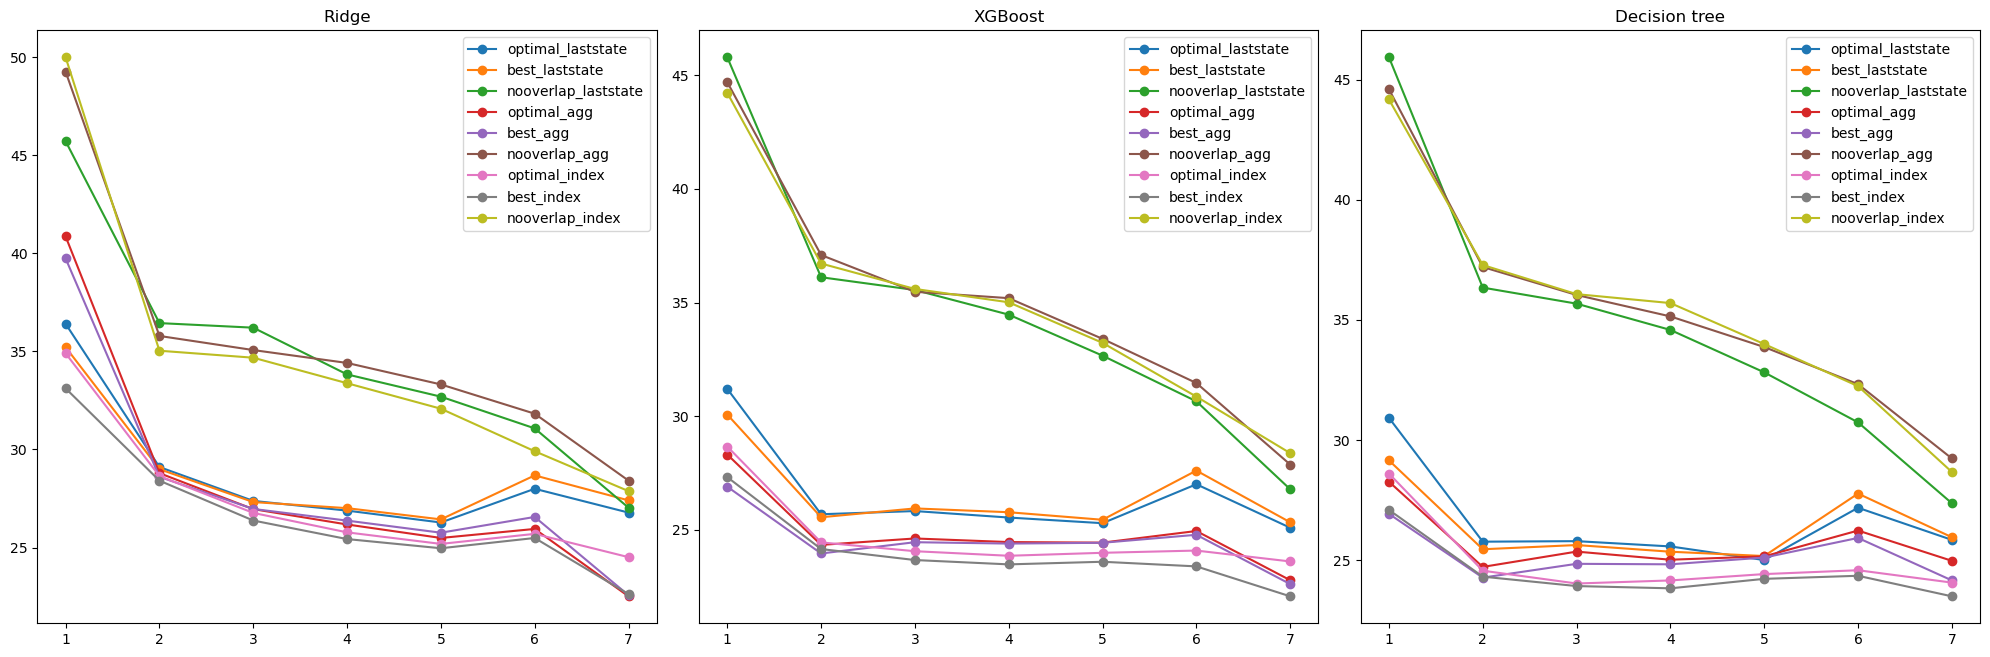

In [292]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(20,6.67)) 

for idx, (label, subres) in enumerate(final_results.items()):
    ax = axs[idx]
    ax.set_title(label)
    for k, item in subres.items():
        _, _, mae_test_prefix, _, mae_train_prefix = item
        indices_dict = dict()

        for i, index in enumerate(mae_test_prefix.index):
            parts = index.split('_')
            identifier = parts[0]
            suffix = parts[-1]
            suffix = suffix if suffix.isdigit() else '1'

            if suffix in indices_dict:
                indices_dict[suffix].append(i)
            else:
                indices_dict[suffix] = [i]

        res_test = np.array(mae_test_prefix)
        to_p = []
        for key, value in indices_dict.items():
            if key == '00001':
                to_p.append(np.mean(res_test[indices_dict[key]]))
            if len(key) == 1 and int(key) in list(range(2, 8)):
                to_p.append(np.mean(res_test[indices_dict[key]]))
        ax.plot(list(range(1, 8)), to_p, marker="o", label=k)

    ax.legend()

plt.tight_layout() 
plt.show()


In [293]:
subres

{'optimal_laststate': (DecisionTreeRegressor(max_depth=28, min_samples_leaf=6),
  23.546566139296655,
  case:concept:name
  2000033505_00001      44.490532
  2000033505_00001_2     9.999934
  2000033505_00001_3    44.490532
  2000033505_00001_4    44.490532
  2000033505_00001_5    44.490532
                          ...    
  4508076335_00010      40.386206
  4508076335_00010_2    46.568743
  4508076335_00010_3    52.483256
  4508076335_00010_4    41.203756
  4508076335_00010_5    50.286000
  Name: remtime, Length: 269333, dtype: float64,
  26.063718021537532,
  case:concept:name
  2000000000_00001       5.677367
  2000000000_00001_2     5.677367
  2000000000_00001_3     5.677367
  2000000000_00001_4     5.677367
  2000000000_00001_5    16.414354
                          ...    
  4508048892_00260      62.315073
  4508048892_00270      61.578382
  4508048892_00280      53.420234
  4508049008_00010      53.420234
  4508076160_00010      46.114230
  Name: remtime, Length: 414824, dtype:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


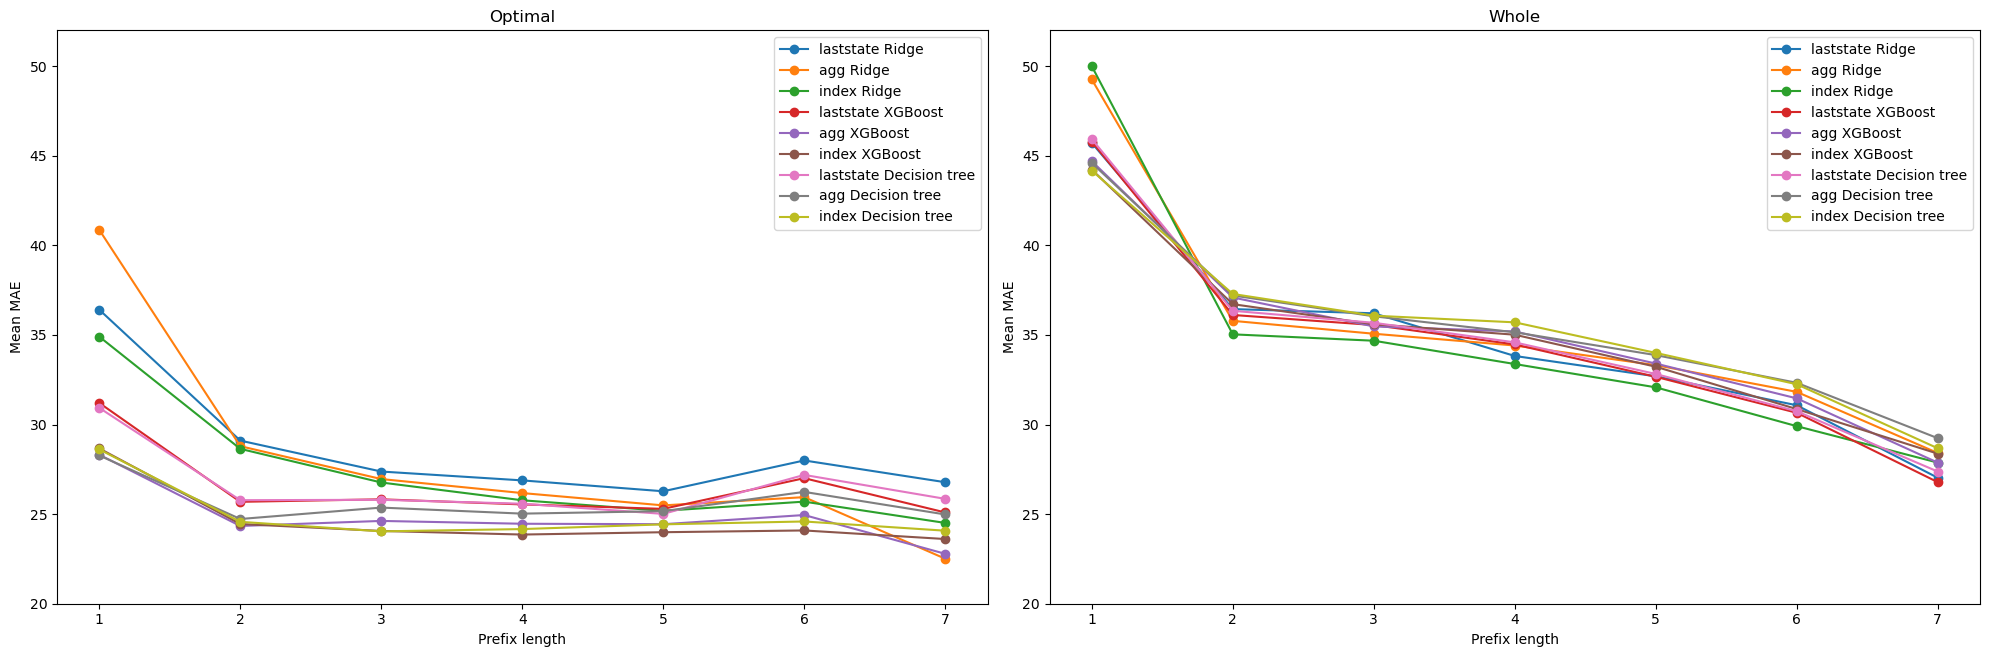

In [348]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20,6.67)) 
for idx, splitmethod in enumerate(['optimal', 'nooverlap']):
    ax = axs[idx]
    ax.set_title(['Optimal', 'Whole'][idx])
    for label, subres in final_results.items():
        
        for k, item in subres.items():
            if splitmethod in k:
                _, _, mae_test_prefix, _, mae_train_prefix = item
                indices_dict = dict()
        
                for i, index in enumerate(mae_test_prefix.index):
                    parts = index.split('_')
                    identifier = parts[0]
                    suffix = parts[-1]
                    suffix = suffix if suffix.isdigit() else '1'
        
                    if suffix in indices_dict:
                        indices_dict[suffix].append(i)
                    else:
                        indices_dict[suffix] = [i]
        
                res_test = np.array(mae_test_prefix)
                to_p = []
                for key, value in indices_dict.items():
                    if key == '00001':
                        to_p.append(np.mean(res_test[indices_dict[key]]))
                    if len(key) == 1 and int(key) in list(range(2, 8)):
                        to_p.append(np.mean(res_test[indices_dict[key]]))
                ax.plot(list(range(1, 8)), to_p, marker="o", label=k.split('_')[-1] + ' ' + label)
        
            ax.legend()
            ax.set_xlabel('Prefix length')
            ax.set_ylabel('Mean MAE')
            ax.set_ylim([20, 52])

plt.tight_layout() 
plt.show()
